# Imports

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from tqdm import tqdm


# Config

In [13]:
class Config:
    # Date ranges
    TRAIN_START_DATE = "2018-05-02T08:44:39.292059872Z"
    TRAIN_END_DATE = "2018-06-25T08:03:24.466039977Z"
    TEST_START_DATE = "2018-06-25T08:03:24.466039977Z"
    TEST_END_DATE = "2018-06-28T23:56:46.421875446Z"

    # Data files
    DATA_DIR = r"C:\Users\cinco\Desktop\DATA FOR SCRIPTS\data bento data\test2"
    FILE_PREFIX = "xnas.itch_NVDA_"
    FILE_SUFFIX = ".csv"

    # Model parameters
    BATCH_SIZE = 32
    HIDDEN_SIZE = 64
    NUM_LAYERS = 2
    LEARNING_RATE = 0.001
    EPOCHS = 2
    SEQUENCE_LENGTH = 100
    PREDICTION_LENGTH = 30

    # Training parameters
    NUM_WORKERS = 0
    RANDOM_SEED = 42

    @classmethod
    def validate_dates(cls):
        try:
            train_start = pd.to_datetime(cls.TRAIN_START_DATE, utc=True)
            train_end = pd.to_datetime(cls.TRAIN_END_DATE, utc=True)
            test_start = pd.to_datetime(cls.TEST_START_DATE, utc=True)
            test_end = pd.to_datetime(cls.TEST_END_DATE, utc=True)
            
            print(f"\nValidating date ranges:")
            print(f"Train period: {train_start} to {train_end}")
            print(f"Test period: {test_start} to {test_end}")
            
            assert train_start < train_end, "Training start date must be before training end date"
            assert test_start < test_end, "Test start date must be before test end date"
            assert train_end <= test_start, "Training end date should be before or equal to test start date"
            
            # Adjust test_start if it's equal to train_end
            if train_end == test_start:
                cls.TEST_START_DATE = (test_start + pd.Timedelta(microseconds=1)).isoformat()
                print(f"Adjusted test start date to: {cls.TEST_START_DATE}")
            
            return True
        except Exception as e:
            print(f"Date validation error: {str(e)}")
            return False

    @classmethod
    def analyze_time_series(cls):
        try:
            all_diffs = []
            csv_files = glob.glob(str(Path(cls.DATA_DIR) / "*.csv"))
            
            for file in csv_files:
                df = pd.read_csv(file)
                df['ts_event'] = pd.to_datetime(df['ts_event'])
                df = df.sort_values('ts_event')
                time_diffs = df['ts_event'].diff().dt.total_seconds()
                all_diffs.extend(time_diffs.dropna().tolist())
            
            if not all_diffs:
                raise ValueError("No valid time differences found in the data")
            
            median_diff = np.median(all_diffs)
            mean_diff = np.mean(all_diffs)
            std_diff = np.std(all_diffs)
            
            typical_observations_per_30min = int((30 * 60) / median_diff)
            cls.SEQUENCE_LENGTH = min(max(typical_observations_per_30min, 10), 100)
            
            typical_observations_per_5min = int((5 * 60) / median_diff)
            cls.PREDICTION_LENGTH = min(max(typical_observations_per_5min, 5), 30)
            
            print(f"\nTime Series Analysis Results:")
            print(f"Median time between observations: {median_diff:.2f} seconds")
            print(f"Mean time between observations: {mean_diff:.2f} seconds")
            print(f"Standard deviation: {std_diff:.2f} seconds")
            print(f"Selected sequence length: {cls.SEQUENCE_LENGTH} observations")
            print(f"Selected prediction length: {cls.PREDICTION_LENGTH} observations")
            
            return True
        except Exception as e:
            print(f"Error analyzing time series: {str(e)}")
            return False
    
    @classmethod
    def get_file_list(cls):
        start_date = pd.to_datetime(cls.TRAIN_START_DATE).date()
        end_date = pd.to_datetime(cls.TEST_END_DATE).date()
        date_range = pd.date_range(start_date, end_date)
        
        file_list = []
        for date in date_range:
            file_name = f"{cls.FILE_PREFIX}{date.strftime('%Y%m%d')}_to_{(date + timedelta(days=1)).strftime('%Y%m%d')}{cls.FILE_SUFFIX}"
            file_path = os.path.join(cls.DATA_DIR, file_name)
            if os.path.exists(file_path):
                file_list.append(file_path)
        
        return file_list

    @classmethod
    def initialize(cls):
        if not cls.validate_dates():
            raise ValueError("Date validation failed")
        if not cls.analyze_time_series():
            print("Warning: Using default sequence and prediction lengths")
        return True


# Data Loading Function


In [14]:
def load_csv_data(file_list, columns=['ts_event', 'price']):
    dfs = []
    for file in file_list:
        df = pd.read_csv(file, usecols=columns)
        dfs.append(df)
    
    df = pd.concat(dfs, ignore_index=True)
    df['ts_event'] = pd.to_datetime(df['ts_event'], utc=True)
    return df.sort_values('ts_event')


In [15]:
def run_with_progress():
    # Initialize config
    Config.initialize()

    # Get file list
    file_list = Config.get_file_list()

    # Load data
    print("Loading data...")
    df = load_csv_data(file_list)

    # Preprocess data
    print("Preprocessing data...")
    train_start = pd.to_datetime(Config.TRAIN_START_DATE, utc=True)
    train_end = pd.to_datetime(Config.TRAIN_END_DATE, utc=True)
    test_start = pd.to_datetime(Config.TEST_START_DATE, utc=True)
    test_end = pd.to_datetime(Config.TEST_END_DATE, utc=True)

    X_train, y_train, X_test, y_test, scaler, test_df = preprocess_data(
        df, train_start, train_end, test_start, test_end, Config.SEQUENCE_LENGTH
    )

    # Create dataset and dataloader for training data
    train_dataset = PriceDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)

    # Initialize model, loss function, and optimizer
    model = LSTMModel(hidden_size=Config.HIDDEN_SIZE, num_layers=Config.NUM_LAYERS)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    # Train the model
    print("Training model...")
    train_model_with_progress(model, train_loader, criterion, optimizer)

    # Make predictions on test data
    print("Making predictions...")
    test_predictions = predict_with_progress(model, X_test, scaler)

    # Create a DataFrame with test predictions
    predictions_df = pd.DataFrame({
        'ts_event': test_df['ts_event'][Config.SEQUENCE_LENGTH:].reset_index(drop=True),
        'predicted_price': test_predictions,
        'actual_price': test_df['price'][Config.SEQUENCE_LENGTH:].reset_index(drop=True)
    })

    # Plot predicted vs actual prices
    plot_predicted_vs_actual(predictions_df)

    print(predictions_df)

# Data Preprocessing Function


In [16]:
def preprocess_data(df, train_start, train_end, test_start, test_end, sequence_length):
    train_mask = (df['ts_event'] >= train_start) & (df['ts_event'] < train_end)
    test_mask = (df['ts_event'] >= test_start) & (df['ts_event'] <= test_end)

    train_df = df[train_mask]
    test_df = df[test_mask]

    scaler = MinMaxScaler()
    train_prices = scaler.fit_transform(train_df['price'].values.reshape(-1, 1))
    test_prices = scaler.transform(test_df['price'].values.reshape(-1, 1))

    X_train, y_train = create_sequences(train_prices, sequence_length)
    X_test, y_test = create_sequences(test_prices, sequence_length)

    return X_train, y_train, X_test, y_test, scaler, test_df

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)


# Custom Dataset


In [17]:
class PriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# LSTM Model


In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Training Function


In [19]:
def train_model_with_progress(model, train_loader, criterion, optimizer):
    model.train()
    for epoch in range(Config.EPOCHS):
        print(f"Epoch [{epoch+1}/{Config.EPOCHS}]")
        pbar = tqdm(total=len(train_loader), unit="batch")
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
        pbar.close()


# Prediction Function


In [20]:
def predict_with_progress(model, test_data, scaler):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        pbar = tqdm(total=len(test_data), unit="prediction")
        for i in range(len(test_data)):
            X = torch.FloatTensor(test_data[i]).unsqueeze(0)
            y_pred = model(X)
            predictions.append(scaler.inverse_transform(y_pred.numpy())[0][0])
            pbar.update(1)
        pbar.close()
    
    return predictions


# Visualization

In [21]:
def plot_train_data(df, train_start, train_end):
    train_df = df[(df['ts_event'] >= train_start) & (df['ts_event'] < train_end)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_df['ts_event'], train_df['price'], label='Actual Price (Train)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Training Data: Actual Prices')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [22]:
def plot_predicted_vs_actual(df, test_start, test_end):
    test_df = df[(df['ts_event'] >= test_start) & (df['ts_event'] <= test_end)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_df['ts_event'], test_df['actual_price'], label='Actual Price (Test)')
    plt.plot(test_df['ts_event'], test_df['predicted_price'], label='Predicted Price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Test Data: Predicted vs Actual Prices')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    rmse = np.sqrt(((test_df['actual_price'] - test_df['predicted_price']) ** 2).mean())
    print(f"Root Mean Square Error: {rmse}")


# Main execution



Validating date ranges:
Train period: 2018-05-02 08:44:39.292059872+00:00 to 2018-06-25 08:03:24.466039977+00:00
Test period: 2018-06-25 08:03:24.466039977+00:00 to 2018-06-28 23:56:46.421875446+00:00
Adjusted test start date to: 2018-06-25T08:03:24.466040977+00:00

Time Series Analysis Results:
Median time between observations: 0.00 seconds
Mean time between observations: 1.19 seconds
Standard deviation: 23.53 seconds
Selected sequence length: 100 observations
Selected prediction length: 30 observations


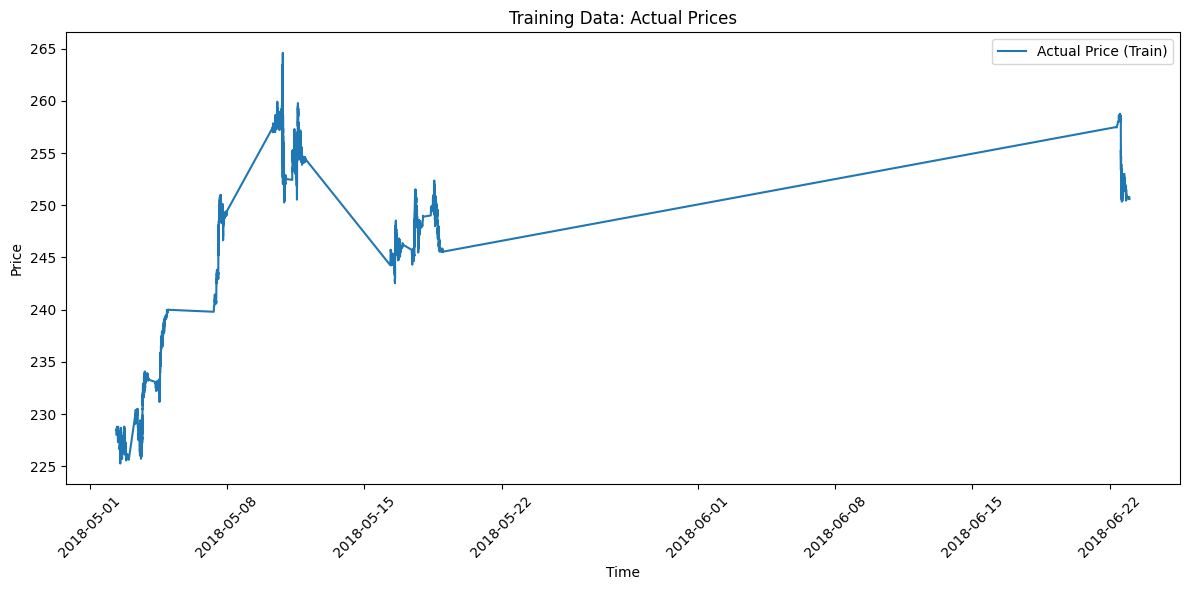

Epoch [1/2]


100%|██████████| 14127/14127 [03:59<00:00, 58.90batch/s, Loss=0.0000]


Epoch [2/2]


100%|██████████| 116070/116070 [01:52<00:00, 1028.61prediction/s]


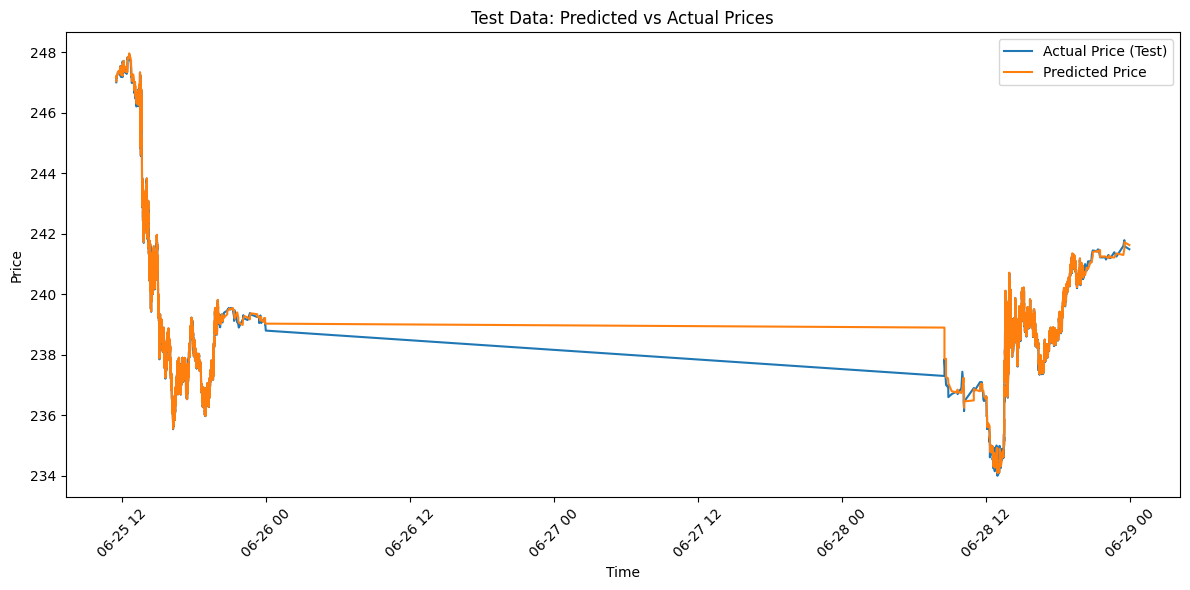

Root Mean Square Error: 0.02999191961845777
                                  ts_event  predicted_price  actual_price
0      2018-06-25 11:29:08.633862389+00:00       247.049698        247.01
1      2018-06-25 11:29:08.633862389+00:00       247.045380        247.01
2      2018-06-25 11:29:16.972434687+00:00       247.042175        247.15
3      2018-06-25 11:29:16.972434687+00:00       247.147232        247.16
4      2018-06-25 11:29:19.083478062+00:00       247.184814        247.16
...                                    ...              ...           ...
116065 2018-06-28 22:52:24.937021169+00:00       241.350571        241.25
116066 2018-06-28 23:26:52.431246760+00:00       241.300995        241.60
116067 2018-06-28 23:31:48.214531524+00:00       241.508179        241.79
116068 2018-06-28 23:32:16.466756703+00:00       241.720322        241.59
116069 2018-06-28 23:56:46.421875446+00:00       241.628372        241.49

[116070 rows x 3 columns]


In [23]:
if __name__ == "__main__":
    # Initialize config
    Config.initialize()

    # Get file list
    file_list = Config.get_file_list()

    # Load data
    df = load_csv_data(file_list)

    # Preprocess data
    train_start = pd.to_datetime(Config.TRAIN_START_DATE, utc=True)
    train_end = pd.to_datetime(Config.TRAIN_END_DATE, utc=True)
    test_start = pd.to_datetime(Config.TEST_START_DATE, utc=True)
    test_end = pd.to_datetime(Config.TEST_END_DATE, utc=True)

    # Plot training data
    plot_train_data(df, train_start, train_end)

    X_train, y_train, X_test, y_test, scaler, test_df = preprocess_data(
        df, train_start, train_end, test_start, test_end, Config.SEQUENCE_LENGTH
    )

    # Create dataset and dataloader for training data
    train_dataset = PriceDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)
    
    # Initialize model, loss function, and optimizer
    model = LSTMModel(hidden_size=Config.HIDDEN_SIZE, num_layers=Config.NUM_LAYERS)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    
    # Train the model
    train_model_with_progress(model, train_loader, criterion, optimizer)
    
    # Make predictions on test data
    test_predictions = predict_with_progress(model, X_test, scaler)
    
    # Create a DataFrame with test predictions
    predictions_df = pd.DataFrame({
        'ts_event': test_df['ts_event'][Config.SEQUENCE_LENGTH:].reset_index(drop=True),
        'predicted_price': test_predictions,
        'actual_price': test_df['price'][Config.SEQUENCE_LENGTH:].reset_index(drop=True)
    })
    
    # Plot predicted vs actual prices for test data
    plot_predicted_vs_actual(predictions_df, test_start, test_end)
    
    print(predictions_df)
